In [946]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [947]:
# Frecuencia MCU = 16 MHz
def ticks_to_sec(ticks):
    return ticks / 16e6

def ticks_to_msec(ticks):
    return ticks / 16e6 * 1e3

def ticks_to_usec(ticks):
    return ticks / 16e6 * 1e6

In [948]:
tipo = 'M' # Orchestra ('O') o Minimal ('M')
topo = 'E' # Estrella ('E') o Lineal ('L')
motes_q = 10 # Cantidad de motes: [5, ... , 10]

In [949]:
tipo_path = 'orchestra\\' if tipo == 'O' else 'minimal\\'
topo_path = 'estrella\\' if topo == 'E' else 'lineal\\'
df = pd.read_excel('procesados\\' + tipo_path + topo_path + 'analisis_' + topo + '_' + str(motes_q) + '.xlsx', sheet_name='Hoja2')
df_final = pd.DataFrame()
df_avg = pd.DataFrame()

In [950]:
# df.columns

In [951]:
# Agregar intensidad y slotframe a df_final
df_final[['intensidad', 'slotframe']] = df[['intensidad', 'slotframe']]
# Agregar intensidad a df_avg
df_avg['intensidad'] = df['intensidad']
# Obtener intensidades y slotframes probados
intensidad = sorted(df['intensidad'].unique())
slotframe = sorted(df['slotframe'].unique())

### PDR vs Intensidad

In [952]:
# Agregar datos de PDR
motes_extra = 2 if topo == 'E' else 1 # Se agrega nodo adicional por nodo aislado si es estrella
for i in range(2, motes_q + motes_extra):
    df['pdr_' + str(i)] = df['pkt_rcv_' + str(i)] / df['pkt_sent_' + str(i)] * 100

In [953]:
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [954]:
pdr_cols = [col for col in df if col.startswith('pdr')]
df[pdr_cols]
df.sort_values(by=['intensidad', 'slotframe'], inplace=True)
df[['intensidad', 'slotframe'] + pdr_cols]

,intensidad,slotframe,pdr_3,pdr_4,pdr_5,pdr_6,pdr_7,pdr_8,pdr_9,pdr_10,pdr_11
7,3,7,100.0,100.0,100.0,100.0,99.828473,100.0,99.827288,100.0,100.0
1,3,17,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
4,3,27,100.0,100.0,100.0,100.0,99.827883,100.0,99.658703,100.0,100.0
8,8,7,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
2,8,17,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
5,8,27,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
6,19,7,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
0,19,17,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0
3,19,27,100.0,100.0,100.0,100.0,100.000000,NaN,100.000000,100.0,100.0


In [955]:
# PDR de la red, dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'pdr'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][pdr_cols].mean(axis='columns')

### Delay vs Intensidad

In [956]:
# Reemplazar -1 por NaN
df.replace(to_replace=-1, value=np.nan, inplace=True)
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [957]:
delay_cols = [col for col in df if 'avg' in col]
df[['intensidad', 'slotframe'] + delay_cols]

,intensidad,slotframe,delays_3_avg,delays_4_avg,delays_5_avg,delays_6_avg,delays_7_avg,delays_8_avg,delays_9_avg,delays_10_avg,delays_11_avg
7,3,7,4358,4803,6079,3908,3528,2518.0,7668,4712,1922
1,3,17,6334,238,1059,587,6065,3831.0,4393,6516,3016
4,3,27,461,3347,4854,1588,4195,1847.0,7032,5912,7321
8,8,7,7249,1645,10,4354,6944,6381.0,1141,3593,4687
2,8,17,5234,3916,4244,4716,5206,2683.0,10,4182,3391
5,8,27,7387,1188,191,3655,7471,4714.0,3982,4798,3157
6,19,7,4604,5131,1066,1633,4431,6136.0,3704,5678,10
0,19,17,4525,1125,6864,1749,6115,1532.0,1172,4691,2783
3,19,27,6054,5008,1079,1501,4008,NaN,132,5959,6799


In [958]:
# delay de la red, dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'delay'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][delay_cols].mean(axis='columns').apply(ticks_to_usec)

### Duty Cycle vs Intensidad

#### TIEMPO TOTAL ENERGEST

In [959]:
# Agregar datos de Tiempo Total = CPU + LPM + DEEP LPM
motes_extra = 2 if topo == 'E' else 1 # Se agrega nodo adicional por nodo aislado si es estrella
for i in range(1, motes_q + motes_extra):
    df['t_total_' + str(i)] = df['duty_cycle_' + str(i) + '_CPU'] + df['duty_cycle_' + str(i) + '_LPM'] \
        + df['duty_cycle_' + str(i) + '_DEEP LPM']

In [960]:
# Quedarse con columnas relativas a t_total, correspondientes a nodos sender
radio_on_cols = [col for col in df if col.startswith('t_total') and col.split("_")[-1] != '1']
df[['intensidad', 'slotframe'] + radio_on_cols]

,intensidad,slotframe,t_total_2,t_total_3,t_total_4,t_total_5,t_total_6,t_total_7,t_total_8,t_total_9,t_total_10,t_total_11
7,3,7,58922238,58891006,58924030,58923006,58922750,58945790,58924542,58963710,58902526,58886910
1,3,17,58922238,58878206,58910718,58925054,58955006,58861566,58949631,58912766,58928638,58920446
4,3,27,58922238,58922238,58906622,58951422,58903038,58967550,58926334,58946343,58869246,58947838
8,8,7,58945278,58868222,58835198,58774782,58889214,58852606,58925566,58894334,58754302,58816254
2,8,17,58945278,58905598,58715902,58971646,58889470,58939902,58842110,58743806,58893585,58694654
5,8,27,58945278,58840830,58904062,58888446,58739710,58921726,58716926,58719742,58778622,58841388
6,19,7,58811134,58334718,58716670,58479614,58634750,58683390,58694398,58588414,58502398,58753790
0,19,17,58811134,58882046,58751742,58665470,58928638,58454270,58572030,58408190,58693118,58601726
3,19,27,58811134,58818302,58408190,58882046,58907390,58436606,58622206,58839294,58471934,58670590


In [961]:
# Tiempo total de la red (solo senders), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 't_total'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][radio_on_cols].mean(axis='columns')

In [962]:
# Agregar t_total en df_avg
df_avg['t_total'] = df_final['t_total']

In [963]:
df_final

,intensidad,slotframe,pdr,delay,t_total
0,19,17,100.000000,212.194444,58676836.4
1,3,17,100.000000,222.493056,58916426.9
2,8,17,100.000000,233.208333,58854195.1
3,19,27,100.000000,238.593750,58686769.2
4,3,27,99.942954,253.868056,58926286.9
5,8,27,100.000000,253.770833,58829673.0
6,19,7,100.000000,224.951389,58619927.6
7,3,7,99.961751,274.277778,58920650.8
8,8,7,100.000000,250.027778,58855575.6


#### RADIO ON

In [964]:
# Agregar datos de Radio ON
motes_extra = 2 if topo == 'E' else 1 # Se agrega nodo adicional por nodo aislado si es estrella
for i in range(1, motes_q + motes_extra):
    if df['duty_cycle_' + str(i) + '_TRANSMIT'].max() > 0: # Contar solo los nodos que se enganchan
        df['radio_on_' + str(i)] = df['duty_cycle_' + str(i) + '_Radio LISTEN'] + df['duty_cycle_' + str(i) + '_TRANSMIT']

In [965]:
# Quedarse con columnas relativas a radio_ON, correspondientes a nodos sender
radio_on_cols = [col for col in df if col.startswith('radio_on') and col.split("_")[-1] != '1']
df[['intensidad', 'slotframe'] + radio_on_cols]

,intensidad,slotframe,radio_on_3,radio_on_4,radio_on_5,radio_on_6,radio_on_7,radio_on_8,radio_on_9,radio_on_10,radio_on_11
7,3,7,2411994,2640354,2551570,2414223,2589271,3266983,2550978,2481171,2397303
1,3,17,2398444,3239690,2532376,2488216,2308918,3196086,2545197,2443294,2312446
4,3,27,2328242,2676231,2422437,3053508,2338828,3269413,2555344,2437885,2581981
8,8,7,2376184,2723434,3018700,2461777,2346389,3175385,3603501,2475260,2341803
2,8,17,2363292,3176661,2482042,2465068,2384446,3194613,2908528,2460735,2329088
5,8,27,2451855,2819651,2693700,2488035,2426735,3172179,3148860,2438591,2746011
6,19,7,3143499,2645849,4937619,4452144,2470049,2429410,3252546,3185502,2924158
0,19,17,2380144,2779257,2598889,3411851,2333567,2776693,3115902,2483496,2366064
3,19,27,2369023,2763303,4143393,3307361,2346098,2782169,2856476,3174322,2569438


In [966]:
# Consumo "Radio ON" de la red (solo senders), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'radio_on'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][radio_on_cols].mean(axis='columns')

In [967]:
df_final

,intensidad,slotframe,pdr,delay,t_total,radio_on
0,19,17,100.000000,212.194444,58676836.4,2.693985e+06
1,3,17,100.000000,222.493056,58916426.9,2.607185e+06
2,8,17,100.000000,233.208333,58854195.1,2.640497e+06
3,19,27,100.000000,238.593750,58686769.2,2.923509e+06
4,3,27,99.942954,253.868056,58926286.9,2.629319e+06
5,8,27,100.000000,253.770833,58829673.0,2.709513e+06
6,19,7,100.000000,224.951389,58619927.6,3.271197e+06
7,3,7,99.961751,274.277778,58920650.8,2.589316e+06
8,8,7,100.000000,250.027778,58855575.6,2.724715e+06


#### LISTEN

In [968]:
# Quedarse con columnas relativas a LISTEN, correspondientes a nodos sender...
listen_si_cols = list() # ...considerando nodos que SÍ se engancharon
listen_no_cols = list() # ...considerando nodos que NO se engancharon
for col in df:
    if 'LISTEN' in col: # columnas de LISTEN
        mote_id = col.split("_")[-2] # formato: duty_cycle_3_Radio LISTEN
        if mote_id != '1': # solo nodos sender
            aux_col = 'duty_cycle_' + mote_id + '_TRANSMIT'
            if aux_col in df.columns and df[aux_col].max() > 0: # nodos que se engancharon
                    listen_si_cols.append(col)
            else:
                    listen_no_cols.append(col)

In [969]:
print("Nodos sender que SÍ se engancharon:")
df[['intensidad', 'slotframe'] + listen_si_cols]

Nodos sender que SÍ se engancharon:


,intensidad,slotframe,duty_cycle_3_Radio LISTEN,duty_cycle_4_Radio LISTEN,duty_cycle_5_Radio LISTEN,duty_cycle_6_Radio LISTEN,duty_cycle_7_Radio LISTEN,duty_cycle_8_Radio LISTEN,duty_cycle_9_Radio LISTEN,duty_cycle_10_Radio LISTEN,duty_cycle_11_Radio LISTEN
7,3,7,2360929,2554581,2501461,2363967,2538853,3221547,2500711,2399049,2347166
1,3,17,2283207,3194741,2483334,2371059,2259784,3143497,2494064,2391075,2261833
4,3,27,2276642,2559376,2307870,3008437,2286155,3224474,2503559,2386446,2531172
8,8,7,2333523,2702467,2997135,2418493,2325557,3154872,3581970,2432828,2320710
2,8,17,2343382,3157171,2461994,2445023,2343027,3175306,2887927,2440873,2308475
5,8,27,2409339,2798721,2672766,2426014,2406070,3152414,3127446,2417983,2724872
6,19,7,3131477,2634151,4925356,4439796,2430846,2417517,3229884,3164396,2901582
0,19,17,2358150,2766340,2586686,3398322,2321770,2763761,3093433,2461362,2335544
3,19,27,2347359,2750872,4130808,3294022,2324854,2780158,2842940,3153243,2547810


In [970]:
# consumo "Listen" de la red (senders que SÍ se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'listen_si'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][listen_si_cols].mean(axis='columns')

In [971]:
# consumo "Listen" de la red (senders que SÍ se engancharon), dada una intensidad
df_aux = df.groupby('intensidad')[listen_si_cols].mean().mean(axis='columns').reset_index()
df_aux.columns = ['intensidad', 'listen_si_avg']
df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [972]:
df.groupby('intensidad').mean().reset_index()

,intensidad,slotframe,pkt_sent_2,pkt_sent_3,pkt_sent_4,pkt_sent_5,pkt_sent_6,pkt_sent_7,pkt_sent_8,pkt_sent_9,...,radio_on_1,radio_on_3,radio_on_4,radio_on_5,radio_on_6,radio_on_7,radio_on_8,radio_on_9,radio_on_10,radio_on_11
0,3,17.0,0.0,583.333333,580.666667,583.666667,582.333333,581.666667,576.333333,581.666667,...,2568.000000,2.379560e+06,2.852092e+06,2.502128e+06,2.651982e+06,2.412339e+06,3.244161e+06,2.550506e+06,2.454117e+06,2.430577e+06
1,8,17.0,0.0,222.000000,218.333333,219.666667,221.000000,222.333333,218.000000,218.000000,...,1304.000000,2.397110e+06,2.906582e+06,2.731481e+06,2.471627e+06,2.385857e+06,3.180726e+06,3.220296e+06,2.458195e+06,2.472301e+06
2,19,17.0,0.0,93.000000,93.000000,91.333333,92.000000,93.333333,62.333333,92.333333,...,6588.666667,2.630889e+06,2.729470e+06,3.893300e+06,3.723785e+06,2.383238e+06,2.662757e+06,3.074975e+06,2.947773e+06,2.619887e+06


In [973]:
print("Nodos sender que NO se engancharon:")
df[['intensidad', 'slotframe'] + listen_no_cols]

Nodos sender que NO se engancharon:


,intensidad,slotframe,duty_cycle_2_Radio LISTEN
7,3,7,58889697
1,3,17,58889697
4,3,27,58889697
8,8,7,58889697
2,8,17,58889697
5,8,27,58889697
6,19,7,58758625
0,19,17,58758625
3,19,27,58758625


In [974]:
# consumo "Listen" de la red (senders que NO se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'listen_no'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][listen_no_cols].mean(axis='columns')

In [975]:
# consumo "Listen" de la red (senders que NO se engancharon), dada una intensidad
if listen_no_cols: # Si la lista no está vacía
    df_aux = df.groupby('intensidad')[listen_no_cols].mean().mean(axis='columns').reset_index()
    df_aux.columns = ['intensidad', 'listen_no_avg']
    df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [976]:
df_final

,intensidad,slotframe,pdr,delay,t_total,radio_on,listen_si,listen_no
0,19,17,100.000000,212.194444,58676836.4,2.693985e+06,2.676152e+06,58758625.0
1,3,17,100.000000,222.493056,58916426.9,2.607185e+06,2.542510e+06,58889697.0
2,8,17,100.000000,233.208333,58854195.1,2.640497e+06,2.618131e+06,58889697.0
3,19,27,100.000000,238.593750,58686769.2,2.923509e+06,2.908007e+06,58758625.0
4,3,27,99.942954,253.868056,58926286.9,2.629319e+06,2.564903e+06,58889697.0
5,8,27,100.000000,253.770833,58829673.0,2.709513e+06,2.681736e+06,58889697.0
6,19,7,100.000000,224.951389,58619927.6,3.271197e+06,3.252778e+06,58758625.0
7,3,7,99.961751,274.277778,58920650.8,2.589316e+06,2.532029e+06,58889697.0
8,8,7,100.000000,250.027778,58855575.6,2.724715e+06,2.696395e+06,58889697.0


#### TRANSMIT

In [977]:
# Reemplazar 0 por NaN
df.replace(to_replace=0, value=np.nan, inplace=True)
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [978]:
# Quedarse con columnas relativas a radio_ON, correspondientes a nodos sender
tx_cols = [col for col in df if 'TRANSMIT' in col and col.split("_")[-2] != '1']
df[['intensidad', 'slotframe'] + tx_cols]

,intensidad,slotframe,duty_cycle_3_TRANSMIT,duty_cycle_4_TRANSMIT,duty_cycle_5_TRANSMIT,duty_cycle_6_TRANSMIT,duty_cycle_7_TRANSMIT,duty_cycle_8_TRANSMIT,duty_cycle_9_TRANSMIT,duty_cycle_10_TRANSMIT,duty_cycle_11_TRANSMIT
7,3,7,51065,85773,50109,50256,50418,45436,50267,82122,50137
1,3,17,115237,44949,49042,117157,49134,52589,51133,52219,50613
4,3,27,51600,116855,114567,45071,52673,44939,51785,51439,50809
8,8,7,42661,20967,21565,43284,20832,20513,21531,42432,21093
2,8,17,19910,19490,20048,20045,41419,19307,20601,19862,20613
5,8,27,42516,20930,20934,62021,20665,19765,21414,20608,21139
6,19,7,12022,11698,12263,12348,39203,11893,22662,21106,22576
0,19,17,21994,12917,12203,13529,11797,12932,22469,22134,30520
3,19,27,21664,12431,12585,13339,21244,2011,13536,21079,21628


In [979]:
# consumo "TRANSMIT" de la red (solo senders), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'tx'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][tx_cols].mean(axis='columns')

#### CPU

In [980]:
# Quedarse con columnas relativas a CPU, correspondientes a nodos sender...
cpu_si_cols = list() # ...considerando nodos que SÍ se engancharon
cpu_no_cols = list() # ...considerando nodos que NO se engancharon
for col in df:
    if 'CPU' in col: # columnas de CPU
        mote_id = col.split("_")[-2] # formato: duty_cycle_3_CPU
        if mote_id != '1': # solo nodos sender
            aux_col = 'duty_cycle_' + mote_id + '_TRANSMIT'
            if aux_col in df.columns and df[aux_col].max() > 0: # nodos que se engancharon
                    cpu_si_cols.append(col)
            else:
                    cpu_no_cols.append(col)

In [981]:
print("Nodos sender que SÍ se engancharon:")
df[['intensidad', 'slotframe'] + cpu_si_cols]

Nodos sender que SÍ se engancharon:


,intensidad,slotframe,duty_cycle_3_CPU,duty_cycle_4_CPU,duty_cycle_5_CPU,duty_cycle_6_CPU,duty_cycle_7_CPU,duty_cycle_8_CPU,duty_cycle_9_CPU,duty_cycle_10_CPU,duty_cycle_11_CPU
7,3,7,1359970,1646757,1312224,1304999,1380641,1434140,1307807,1563168,1301377
1,3,17,1798321,1367321,1374084,1831415,1298477,1375597,1315864,1374968,1316600
4,3,27,1354727,1942539,1816389,1428656,1299454,1382269,1328448,1315314,1375671
8,8,7,756943,585802,637608,802480,585483,641590,680031,803117,560048
2,8,17,560906,619612,567506,567849,759082,617806,608836,566496,562379
5,8,27,758530,591645,585699,960462,569389,623333,620578,568161,598213
6,19,7,361110,321294,469013,447198,590175,305198,482518,441196,430993
0,19,17,390125,333537,315879,397137,299951,334231,443948,395896,501949
3,19,27,389412,328785,420093,389506,389271,235937,354040,435105,405156


In [982]:
# consumo "CPU" de la red (senders que SÍ se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'cpu_si'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][cpu_si_cols].mean(axis='columns')

In [983]:
# consumo "CPU" de la red (senders que SÍ se engancharon), dada una intensidad
df_aux = df.groupby('intensidad')[cpu_si_cols].mean().mean(axis='columns').reset_index()
df_aux.columns = ['intensidad', 'cpu_si_avg']
df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [984]:
print("Nodos sender que NO se engancharon:")
df[['intensidad', 'slotframe'] + cpu_no_cols]

Nodos sender que NO se engancharon:


,intensidad,slotframe,duty_cycle_2_CPU
7,3,7,4231007
1,3,17,4231007
4,3,27,4231007
8,8,7,3833400
2,8,17,3833400
5,8,27,3833400
6,19,7,3687316
0,19,17,3687316
3,19,27,3687316


In [985]:
# consumo "CPU" de la red (senders que NO se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'cpu_no'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][cpu_no_cols].mean(axis='columns')

In [986]:
# consumo "CPU" de la red (senders que NO se engancharon), dada una intensidad
if cpu_no_cols: # Si la lista no está vacía
    df_aux = df.groupby('intensidad')[cpu_no_cols].mean().mean(axis='columns').reset_index()
    df_aux.columns = ['intensidad', 'cpu_no_avg']
    df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [987]:
df_final

,intensidad,slotframe,pdr,delay,t_total,radio_on,listen_si,listen_no,tx,cpu_si,cpu_no
0,19,17,100.000000,212.194444,58676836.4,2.693985e+06,2.676152e+06,58758625.0,17832.777778,3.791837e+05,3687316.0
1,3,17,100.000000,222.493056,58916426.9,2.607185e+06,2.542510e+06,58889697.0,64674.777778,1.450294e+06,4231007.0
2,8,17,100.000000,233.208333,58854195.1,2.640497e+06,2.618131e+06,58889697.0,22366.111111,6.033858e+05,3833400.0
3,19,27,100.000000,238.593750,58686769.2,2.923509e+06,2.908007e+06,58758625.0,15501.888889,3.719228e+05,3687316.0
4,3,27,99.942954,253.868056,58926286.9,2.629319e+06,2.564903e+06,58889697.0,64415.333333,1.471496e+06,4231007.0
5,8,27,100.000000,253.770833,58829673.0,2.709513e+06,2.681736e+06,58889697.0,27776.888889,6.528900e+05,3833400.0
6,19,7,100.000000,224.951389,58619927.6,3.271197e+06,3.252778e+06,58758625.0,18419.000000,4.276328e+05,3687316.0
7,3,7,99.961751,274.277778,58920650.8,2.589316e+06,2.532029e+06,58889697.0,57287.000000,1.401231e+06,4231007.0
8,8,7,100.000000,250.027778,58855575.6,2.724715e+06,2.696395e+06,58889697.0,28319.777778,6.725669e+05,3833400.0


### DataFrames final y avg

In [988]:
df_final.sort_values(by=['intensidad', 'slotframe'], inplace=True)
df_final

,intensidad,slotframe,pdr,delay,t_total,radio_on,listen_si,listen_no,tx,cpu_si,cpu_no
7,3,7,99.961751,274.277778,58920650.8,2.589316e+06,2.532029e+06,58889697.0,57287.000000,1.401231e+06,4231007.0
1,3,17,100.000000,222.493056,58916426.9,2.607185e+06,2.542510e+06,58889697.0,64674.777778,1.450294e+06,4231007.0
4,3,27,99.942954,253.868056,58926286.9,2.629319e+06,2.564903e+06,58889697.0,64415.333333,1.471496e+06,4231007.0
8,8,7,100.000000,250.027778,58855575.6,2.724715e+06,2.696395e+06,58889697.0,28319.777778,6.725669e+05,3833400.0
2,8,17,100.000000,233.208333,58854195.1,2.640497e+06,2.618131e+06,58889697.0,22366.111111,6.033858e+05,3833400.0
5,8,27,100.000000,253.770833,58829673.0,2.709513e+06,2.681736e+06,58889697.0,27776.888889,6.528900e+05,3833400.0
6,19,7,100.000000,224.951389,58619927.6,3.271197e+06,3.252778e+06,58758625.0,18419.000000,4.276328e+05,3687316.0
0,19,17,100.000000,212.194444,58676836.4,2.693985e+06,2.676152e+06,58758625.0,17832.777778,3.791837e+05,3687316.0
3,19,27,100.000000,238.593750,58686769.2,2.923509e+06,2.908007e+06,58758625.0,15501.888889,3.719228e+05,3687316.0


In [989]:
df_avg.sort_values(by='intensidad', inplace=True)
df_avg

,intensidad,t_total,listen_si_avg,listen_no_avg,cpu_si_avg,cpu_no_avg
3,3,58916426.9,2.546481e+06,58889697.0,1.441007e+06,4231007.0
4,3,58926286.9,2.546481e+06,58889697.0,1.441007e+06,4231007.0
5,3,58920650.8,2.546481e+06,58889697.0,1.441007e+06,4231007.0
6,8,58854195.1,2.665421e+06,58889697.0,6.429476e+05,3833400.0
7,8,58829673.0,2.665421e+06,58889697.0,6.429476e+05,3833400.0
8,8,58855575.6,2.665421e+06,58889697.0,6.429476e+05,3833400.0
0,19,58676836.4,2.945646e+06,58758625.0,3.929131e+05,3687316.0
1,19,58686769.2,2.945646e+06,58758625.0,3.929131e+05,3687316.0
2,19,58619927.6,2.945646e+06,58758625.0,3.929131e+05,3687316.0


### Gráficas

#### PDR vs Período

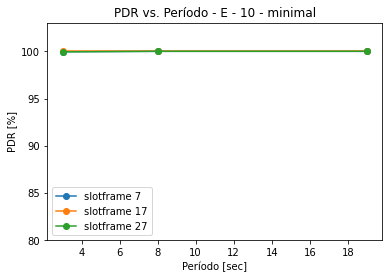

In [990]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['pdr'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(80, 103)
plt.title("PDR vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('PDR [%]')
plt.legend(legend)
plt.show()

#### Delay vs Período

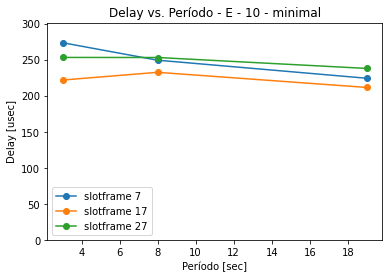

In [991]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['delay'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['delay'].max() + df_final['delay'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Delay vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('Delay [usec]')
plt.legend(legend)
plt.show()

#### Duty Cycle vs Período

##### RADIO ON

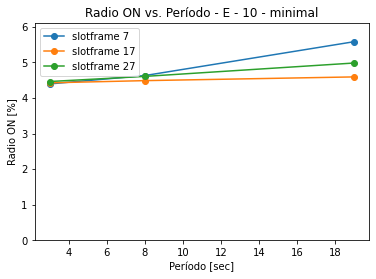

In [992]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['radio_on'] / df_final[df_final['slotframe'] == s]['t_total'] * 100, linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, df_final['radio_on'].max() / df_final['t_total'].max() * 100 + df_final['radio_on'].max() / df_final['t_total'].max() * 100 * 0.1) # Ajustar la escala a 10% más del valor máximo
plt.title("Radio ON vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('Radio ON [%]')
plt.legend(legend)
plt.show()

##### LISTEN

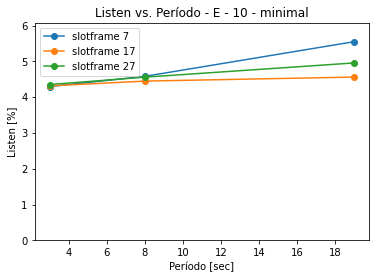

In [993]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['listen_si'] / df_final[df_final['slotframe'] == s]['t_total'] * 100, linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['listen_si'].max() / df_final['t_total'].max() * 100 + df_final['listen_si'].max() / df_final['t_total'].max() * 100 * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Listen vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('Listen [%]')
plt.legend(legend)
plt.show()

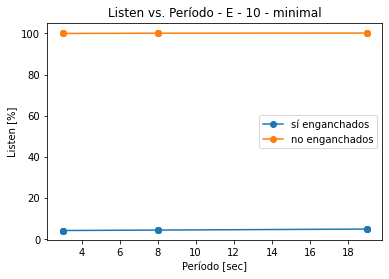

Nodos no enganchados:  ['2']


In [994]:
if listen_no_cols: # Si la lista no está vacía
    plt.plot(df_avg['intensidad'], df_avg['listen_si_avg'] / df_avg['t_total'] * 100, linestyle='-', marker='o')
    plt.plot(df_avg['intensidad'], df_avg['listen_no_avg'] / df_avg['t_total'] * 100, linestyle='-', marker='o')
    plt.title("Listen vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
    plt.xlabel('Período [sec]')
    plt.ylabel('Listen [%]')
    plt.legend(['sí enganchados', 'no enganchados'])
    plt.show()

    print("Nodos no enganchados: ", [i.split("_")[-2] for i in listen_no_cols])

##### TRANSMIT

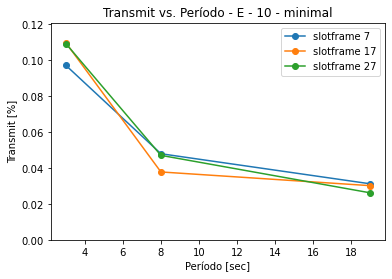

In [995]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['tx'] / df_final[df_final['slotframe'] == s]['t_total'] * 100, linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['tx'].max() / df_final['t_total'].max() * 100 + df_final['tx'].max() / df_final['t_total'].max() * 100 * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Transmit vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('Transmit [%]')
plt.legend(legend)
plt.show()

##### CPU

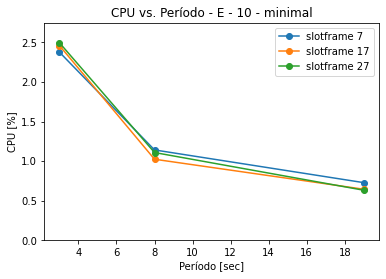

In [996]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['cpu_si'] / df_final[df_final['slotframe'] == s]['t_total'] * 100, linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['cpu_si'].max() / df_final['t_total'].max() * 100 + df_final['cpu_si'].max() / df_final['t_total'].max() * 100 * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("CPU vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Período [sec]')
plt.ylabel('CPU [%]')
plt.legend(legend)
plt.show()

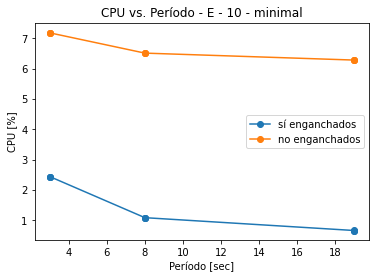

Nodos no enganchados:  ['2']


In [997]:
if cpu_no_cols: # Si la lista no está vacía
    plt.plot(df_avg['intensidad'], df_avg['cpu_si_avg'] / df_avg['t_total'] * 100, linestyle='-', marker='o')
    plt.plot(df_avg['intensidad'], df_avg['cpu_no_avg'] / df_avg['t_total'] * 100, linestyle='-', marker='o')
    plt.title("CPU vs. Período - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
    plt.xlabel('Período [sec]')
    plt.ylabel('CPU [%]')
    plt.legend(['sí enganchados', 'no enganchados'])
    plt.show()

    print("Nodos no enganchados: ", [i.split("_")[-2] for i in listen_no_cols])